In [ ]:
import torch
print(torch.__version__)


2.5.1+cu121


In [1]:
!pip install torchtext==0.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [21]:
class TranslationDataset(Dataset):
    def __init__(self, src_file, tgt_file, src_vocab, tgt_vocab, src_tokenizer, tgt_tokenizer, max_len=50):
        self.src_sentences = self._read_file(src_file)
        self.tgt_sentences = self._read_file(tgt_file)
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.max_len = max_len

    def _read_file(self, file_path):
        with open(file_path, encoding='utf-8') as f:
            return [line.strip() for line in f]

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        src_tokens = self.src_tokenizer(self.src_sentences[idx])[:self.max_len]
        tgt_tokens = self.tgt_tokenizer(self.tgt_sentences[idx])[:self.max_len]

        src_ids = [self.src_vocab[token] for token in src_tokens] + [self.src_vocab['<eos>']]
        tgt_ids = [self.tgt_vocab[token] for token in tgt_tokens] + [self.tgt_vocab['<eos>']]

        return torch.tensor(src_ids), torch.tensor(tgt_ids)

In [22]:
# Tokenizers and vocabulary
src_tokenizer = get_tokenizer('basic_english')
tgt_tokenizer = get_tokenizer('basic_english')

# Build vocabularies
def yield_tokens(file_path, tokenizer):
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            yield tokenizer(line.strip())

src_vocab = build_vocab_from_iterator(yield_tokens('dev.vi', src_tokenizer), specials=['<pad>', '<bos>', '<eos>', '<unk>'])
src_vocab.set_default_index(src_vocab['<unk>'])

tgt_vocab = build_vocab_from_iterator(yield_tokens('dev.en', tgt_tokenizer), specials=['<pad>', '<bos>', '<eos>', '<unk>'])
tgt_vocab.set_default_index(tgt_vocab['<unk>'])

# Datasets and Dataloaders
train_dataset = TranslationDataset('dev.vi', 'dev.en', src_vocab, tgt_vocab, src_tokenizer, tgt_tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: zip(*x))

In [27]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_size, num_heads, num_encoder_layers, num_decoder_layers, dropout=0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.src_embed = nn.Embedding(src_vocab_size, embed_size)
        self.tgt_embed = nn.Embedding(tgt_vocab_size, embed_size)
        self.transformer = nn.Transformer(embed_size, num_heads, num_encoder_layers, num_decoder_layers, dropout=dropout)
        self.fc_out = nn.Linear(embed_size, tgt_vocab_size)
        self.src_pad_idx = src_vocab['<pad>']
        self.tgt_pad_idx = tgt_vocab['<pad>']

    def forward(self, src, tgt):
        src_mask = self._generate_square_subsequent_mask(src.size(0)).to(src.device)
        tgt_mask = self._generate_square_subsequent_mask(tgt.size(0)).to(tgt.device)

        src_padding_mask = self._create_padding_mask(src, self.src_pad_idx).to(src.device)
        tgt_padding_mask = self._create_padding_mask(tgt, self.tgt_pad_idx).to(tgt.device)

        src_embed = self.src_embed(src)
        tgt_embed = self.tgt_embed(tgt)

        transformer_out = self.transformer(
            src_embed, tgt_embed,
            src_mask, tgt_mask,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask
        )
        return self.fc_out(transformer_out)

    def _generate_square_subsequent_mask(self, sz):
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

    def _create_padding_mask(self, seq, pad_idx):
        return (seq == pad_idx).transpose(0, 1)

In [28]:
# Model parameters
embed_size = 512
num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3
dropout = 0.1

model = Seq2SeqTransformer(len(src_vocab), len(tgt_vocab), embed_size, num_heads, num_encoder_layers, num_decoder_layers, dropout).to('cuda')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [29]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss(ignore_index=src_vocab['<pad>'])

def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for src, tgt in dataloader:
        src = nn.utils.rnn.pad_sequence(src, padding_value=src_vocab['<pad>']).to('cuda')
        tgt = nn.utils.rnn.pad_sequence(tgt, padding_value=tgt_vocab['<pad>']).to('cuda')

        tgt_input = tgt[:-1, :]
        tgt_output = tgt[1:, :]

        optimizer.zero_grad()
        output = model(src, tgt_input)
        loss = criterion(output.reshape(-1, output.shape[-1]), tgt_output.reshape(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

# Training loop
epochs = 10
losses = []
for epoch in range(epochs):
    loss = train_epoch(model, train_loader, optimizer, criterion)
    losses.append(loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1/10, Loss: 5.6967
Epoch 2/10, Loss: 4.9554
Epoch 3/10, Loss: 4.5446
Epoch 4/10, Loss: 4.1672
Epoch 5/10, Loss: 3.7917
Epoch 6/10, Loss: 3.3755
Epoch 7/10, Loss: 2.9718
Epoch 8/10, Loss: 2.6049
Epoch 9/10, Loss: 2.2842
Epoch 10/10, Loss: 2.0129


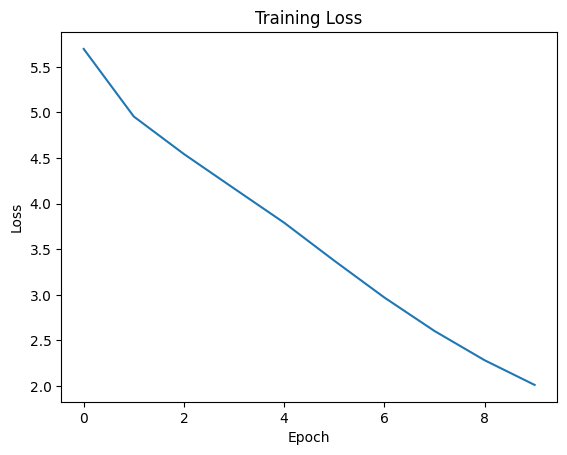

In [30]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [31]:
torch.save(model.state_dict(), 'model_seq2seq_attention.pth')

In [49]:
def translate_sentence(model, sentence, src_vocab, tgt_vocab, src_tokenizer, max_len=50):
    model.eval()
    tokens = src_tokenizer(sentence)[:max_len]
    src_ids = torch.tensor([src_vocab[token] for token in tokens] + [src_vocab['<eos>']]).unsqueeze(1).to('cuda')

    tgt_ids = [tgt_vocab['<bos>']]
    for _ in range(max_len):
        tgt_tensor = torch.tensor(tgt_ids).unsqueeze(1).to('cuda')
        output = model(src_ids, tgt_tensor)
        next_token = output.argmax(2)[-1, :].item()
        tgt_ids.append(next_token)

        if next_token == tgt_vocab['<eos>']:
            break

    translated_tokens = [tgt_vocab.lookup_token(idx) for idx in tgt_ids]
    return ' '.join(translated_tokens[1:-1])

# Thử nghiệm dịch câu
example_sentence = ""
translated = translate_sentence(model, example_sentence, src_vocab, tgt_vocab, src_tokenizer)
print(f"Câu gốc: {example_sentence}")
print(f"Dịch: {translated}")


Câu gốc: bạn tôi
Dịch: mine mine on me as i can .
